In [3]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util.data_loader import (load_dataset, split_train_validation, 
                              custom_random_oversampling, create_csv_submission,
                              change_negative_class)
from util.features_util import keep_features
from util.features_info import FEATURES_DICT, REPLACEMENT_LIST
from util.preprocessing import preprocessing_pipeline
from util.train import reg_logistic_regression
from util.plotting import loss_visualization
from util.evaluation import evaluation_summary
from util.util import init_random_seeds
from util.predict import predict, predict_no_labels

init_random_seeds()

BASE_PATH = os.path.dirname(os.getcwd()) + "/data"

# Data loading

### ⚠️ Note that the `x_sub` here refers to data for which predictions will be made, but for which we don't have the labels! To refer to the data used for local testing we'll use `x_va` and `y_va` (validation).

In [4]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(path_x_train=BASE_PATH + "/x_train.csv",
                                                      path_y_train=BASE_PATH + "/y_train.csv",
                                                      path_x_test=BASE_PATH + "/x_test.csv",
                                                      sub_sample=False)
# Create the feature index dictionary
feature_indexes = dict(zip(feature_names, range(len(feature_names))))

KeyboardInterrupt: 

# Pre-processing

In [ ]:
# Keeping only selected features both in train and validation set
x_train_clean, clean_features, clean_feature_index = keep_features(x_train, FEATURES_DICT.keys(), feature_names, feature_indexes, verbose=False)



# 

In [4]:
# Call to the preprocessing pipeline both for train and test set
# NOTE: the preprocessing automatically performs also normalization

x_train_preprocessed = preprocessing_pipeline(x_train_clean, 
                                              where=clean_features,
                                              feature_index=clean_feature_index,
                                              nan_replacement=REPLACEMENT_LIST,
                                              normalize="mixed")

## Split local data into train and validation

#### From now on we'll use the local train and validation data: `x_tr` and `y_tr` for training and `x_va` and `y_va` for validation

In [5]:
# Translate labels from -1/1 to 0/1
y_train = change_negative_class(y_train[:, 1], current=-1, new=0)

# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(x_train_preprocessed,
                                                  y_train,
                                                  valid_proportion=0.2)

## Data preparation for training

In [6]:
# NO OVERSAMPLING in this version

# Add bias column to the training and validation data
x_tr_bias = np.append(x_tr, np.ones(shape=(x_tr.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)


# Training

In [9]:
from util.train import reg_logistic_regression_hyperparameters
import pickle

lambdas_ = [0.0001, 0.001, 0.01]
gammas = [0.01, 0.05, 0.1, 0.5]
batch_sizes = [500, 5000, 10000]

hyperparameters = {
    "lambda_": lambdas_,
    "gamma": gammas,
    "batch_size": batch_sizes,
    "optimizer": ["sgd"]
}

In [ ]:
res = reg_logistic_regression_hyperparameters(
    x_tr_bias,
    y_tr,
    x_va_bias,
    y_va,
    hyperparameters
)

print(res)

Iteration 0/5000 -> lowest loss inf
Iteration 200/5000 -> lowest loss 2.2721576197821785
Iteration 400/5000 -> lowest loss 1.5450867887259807
Iteration 600/5000 -> lowest loss 1.1029804684836204
Iteration 800/5000 -> lowest loss 0.7962107316219671
Iteration 1000/5000 -> lowest loss 0.5941908574597533
Iteration 1200/5000 -> lowest loss 0.47203068002594645
Iteration 1400/5000 -> lowest loss 0.4024570731459295
Iteration 1600/5000 -> lowest loss 0.3597763617495505
Iteration 1800/5000 -> lowest loss 0.33082694930234513
Iteration 2000/5000 -> lowest loss 0.3098765253689637
Iteration 2200/5000 -> lowest loss 0.2938892008743678
Iteration 2400/5000 -> lowest loss 0.2813962015420893
Iteration 2600/5000 -> lowest loss 0.2716372463887492
Iteration 2800/5000 -> lowest loss 0.2633479423216804
Iteration 3000/5000 -> lowest loss 0.2565084715438245
Iteration 3200/5000 -> lowest loss 0.2510127655219539
Iteration 3400/5000 -> lowest loss 0.24642109595396153
Iteration 3600/5000 -> lowest loss 0.2422842107

In [ ]:
with open('objs_no_oversampling_mixed.pkl', 'wb') as f:
    pickle.dump(res, f)
    

## Load results

In [25]:
with open('objs_no_oversampling_mixed.pkl', 'rb') as f:
    res = pickle.load(f)

res[0].keys()

dict_keys(['lambda_', 'gamma', 'batch_size', 'optimizer', 'best_weights', 'train_loss', 'valid_loss'])

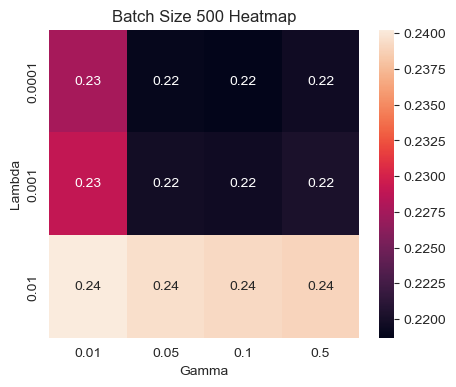

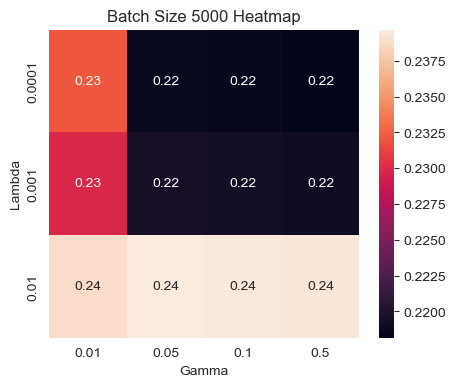

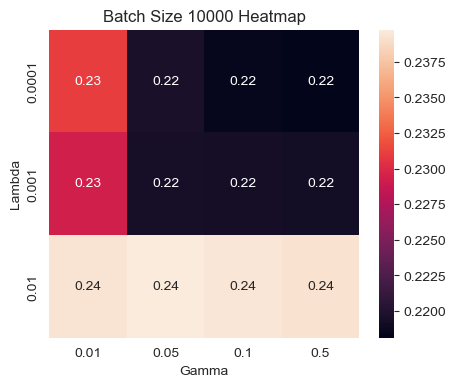

In [26]:
# Plot a heatmap for each batch size
for batch_size in batch_sizes:
    # Filter data for the current batch size
    filtered_res = [d for d in res if d['batch_size'] == batch_size]

    # Create a pivot table for the heatmap
    pivot_res = np.zeros((len(np.unique([d['lambda_'] for d in res])),
                           len(np.unique([d['gamma'] for d in res]))))
    for item in filtered_res:
        lambda_idx = np.where(np.unique([d['lambda_'] for d in res]) == item['lambda_'])[0][0]
        gamma_idx = np.where(np.unique([d['gamma'] for d in res]) == item['gamma'])[0][0]
        pivot_res[lambda_idx, gamma_idx] = item['valid_loss']

    # Create a heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(pivot_res, annot=True, xticklabels=np.unique([d['gamma'] for d in res]),
                yticklabels=np.unique([d['lambda_'] for d in res]))
    plt.xlabel('Gamma')
    plt.ylabel('Lambda')
    plt.title(f'Batch Size {batch_size} Heatmap')
    plt.savefig(os.path.dirname(os.getcwd()) + '/plots/' + f'heatmap_batch_size_{batch_size}_new.png')




## Evaluation on training set

In [27]:
res.sort(key=lambda x: x["valid_loss"], reverse=False)
res_opt = res[0]
print("Optimal hyperparameters: gamma {}, lambda {}, batch size {}".format(res_opt["gamma"],
                                                                           res_opt["lambda_"],
                                                                           res_opt["batch_size"]))
print("Minimum validation loss: {}".format(res_opt["valid_loss"]))
w_opt = res_opt["best_weights"]

Optimal hyperparameters: gamma 0.5, lambda 0.0001, batch size 10000
Minimum validation loss: 0.21811610230352577


In [28]:
predicted_y_tr = predict(x_tr_bias,
                         w_opt,
                         threshold=0.5,
                         negative_label=0)

print("EVALUATION SUMMARY ON TRAINING SET")
evaluation_summary(y_tr, predicted_y_tr)

EVALUATION SUMMARY ON TRAINING SET
Accuracy: 91.65%
Precision: 61.23%
Recall: 15.70%
F1-score: 24.99%


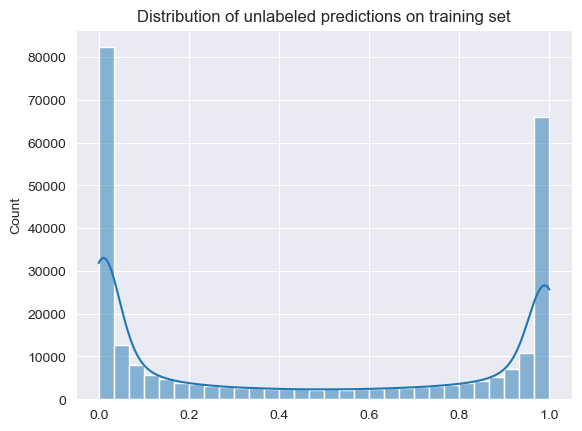

In [22]:
sns.histplot(predict_no_labels(x_tr_bias, w_opt), bins=30, kde=True)
plt.title("Distribution of unlabeled predictions on training set")
plt.show()

# Evaluation on validation set

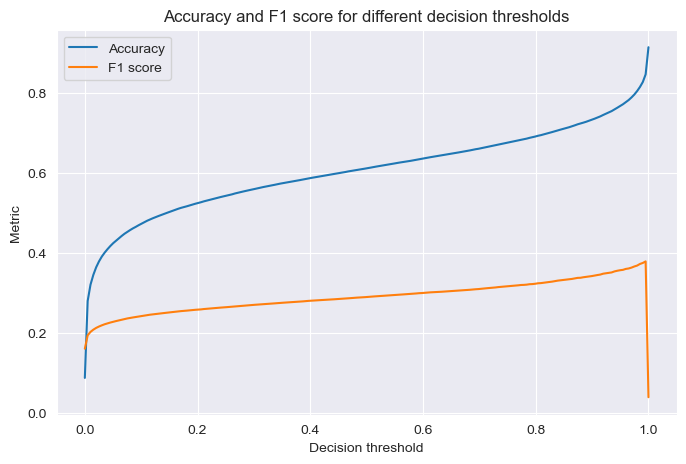

In [23]:
from util.plotting import decision_threshold
opt_threshold = decision_threshold(x_va_bias, w_opt, y_va)

In [24]:
predicted_y_va = predict(x_va_bias,
                         w_opt,
                         threshold=opt_threshold,
                         negative_label=0)
print("EVALUATION SUMMARY ON VALIDATION SET")
evaluation_summary(y_va, predicted_y_va)
print("Optimal threshold -> {:.4f}".format(opt_threshold))

EVALUATION SUMMARY ON VALIDATION SET
Accuracy: 84.67%
Precision: 29.25%
Recall: 53.66%
F1-score: 37.86%
Optimal threshold -> 0.9950


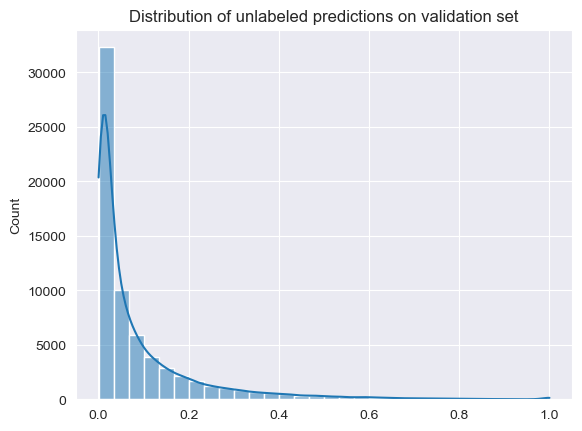

In [17]:
sns.histplot(predict_no_labels(x_va_bias, w_opt), bins=30, kde=True)
plt.title("Distribution of unlabeled predictions on validation set")
plt.show()


---

# COMPUTE RESULT FOR SUBMISSION

In [18]:
ids = x_sub[:, 0]
# Keep only selected features in submission
x_sub_clean, clean_features, clean_feature_index = keep_features(x_sub, FEATURES_DICT.keys(), feature_names, feature_indexes)

x_sub_preprocessed = preprocessing_pipeline(x_sub_clean,
                                            where=clean_features,
                                            feature_index=clean_feature_index,
                                            nan_replacement=REPLACEMENT_LIST)

# Add bias column to the submission data
x_sub_bias = np.append(x_sub_preprocessed, np.ones(shape=(x_sub_preprocessed.shape[0], 1)), axis=1)

Kept 124 features: dict_keys(['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', '_HCVU651', '_CHOLCHK', '_RFCHOL', 'CVDSTRK3', '_ASTHMS1', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', '_DRDXAR1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', '_AGE80', 'MARITAL', '_CHLDCNT', '_EDUCAG', '_INCOMG', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'HTM4', 'WTKG3', '_BMI5', '_SMOKER3', 'USENOW3', 'DRNKANY5', 'DROCDY3_', '_RFBING5', '_DRNKWEK', '_RFDRHV5', 'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', '_FRUTSUM', '_VEGESUM', '_FRTLT1', '_VEGLT1', '_TOTINDA', 'METVL11_', 'METVL21_', 'MAXVO2_', 'ACTIN11_', 'ACTIN21_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', '_MINAC11', '_MINAC21', 'STRFREQ_', 'PA1MIN_', 'PAVIG11_', 'PAVIG21_', 'PA1VIGM_', '_PACAT1', '_PAINDX1', '_PA150R2', '_PA300R2', '_PA30021', '_PASTRNG', 'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'PREDIAB1', 'INSULIN', 'DOCTDIAB', 'CHKHEMO3', 'FEETCHK'

AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
predicted_y_sub = predict(x_sub_bias,
                          w_opt,
                          threshold=opt_threshold,
                          negative_label=-1)

sns.histplot(predict_no_labels(x_sub_bias, w_opt), bins=30, kde=True)

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

sns.histplot(y_train, ax=axs[0])
axs[0].set_title("Distribution of labels in training set")
sns.histplot(predicted_y_sub, ax=axs[1])
axs[1].set_title("Distribution of predictions in submission set")

In [ ]:
# Save predictions to csv file

create_csv_submission(ids=ids,
                      y_pred=predicted_y_sub,
                      path=BASE_PATH + "/submission.csv")